In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, fit_psi_params, psi_params, normalize_matrix, calc_ow, find_directional_radii


### Numerical Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D_3000m.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

z_ssh = ssh_dataset['depth'][:].data
lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = ssh_dataset['uo'][:].data, ssh_dataset['vo'][:].data
u_ssh, v_ssh = np.transpose(u_ssh, axes=(3,2,1,0)), np.transpose(v_ssh, axes=(3,2,1,0)) # LON, LAT, DEPTH, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,:,t], v_ssh[:,:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


In [3]:
df_res = pd.read_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_copernicus_ESPRA.pkl")
df_res


,xc,yc,w,Q,Rc,psi0,A,R,r2_1,Time,...,syc,sq11,sq12,sq22,sRc,sA,sw,spsi0,Data,Method
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",82489.584746,62022.052721,-0.000009,50994.258383,0.992436,2023-10-19 00:00:00,...,-2108.042418,0.972914,-0.103055,1.041144,81761.802118,-0.000009,-0.000037,61442.129397,Numerical,ESPRA
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",74568.109930,55579.064827,-0.000010,46377.603892,0.989580,2023-10-19 23:56:15,...,-2721.266111,0.947328,-0.107706,1.072288,81546.298896,-0.000009,-0.000037,61390.726539,Numerical,ESPRA
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",88487.582092,66281.323785,-0.000008,54708.334682,0.990015,2023-10-21 00:00:00,...,-3128.339941,0.921162,-0.099094,1.103794,81396.843209,-0.000009,-0.000038,61415.338083,Numerical,ESPRA
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",76534.917427,57823.499341,-0.000010,46886.419213,0.993006,2023-10-22 00:00:00,...,-4053.698867,0.899001,-0.076631,1.131550,81328.419122,-0.000009,-0.000038,61525.555770,Numerical,ESPRA
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",78526.099342,59201.426383,-0.000010,50593.667161,0.992719,2023-10-22 23:56:15,...,-5278.160402,0.864076,-0.039283,1.175821,80895.740614,-0.000009,-0.000038,61522.714021,Numerical,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",56270.574725,21072.628684,-0.000007,42245.696889,0.933604,2024-01-31 00:00:00,...,158109.922928,0.951670,-0.101967,1.235045,71348.037352,-0.000005,-0.000022,25967.053413,Numerical,ESPRA
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",52575.980680,19570.681995,-0.000007,36286.868478,0.913641,2024-02-01 00:00:00,...,157995.891402,1.219022,0.051441,1.070873,69669.664384,-0.000005,-0.000023,24660.983574,Numerical,ESPRA
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",65634.448641,26654.913656,-0.000006,34514.576102,0.947802,2024-02-02 00:00:00,...,157985.201138,1.566723,0.167942,0.934028,69561.464185,-0.000005,-0.000025,24077.010440,Numerical,ESPRA
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",105309.297693,35476.409498,-0.000003,34974.184189,0.941040,2024-02-02 23:56:15,...,158292.110118,1.725037,0.282861,0.819334,68751.412943,-0.000005,-0.000025,23395.150273,Numerical,ESPRA


(np.float64(-321973.617001482),
 np.float64(12278.748814644954),
 np.float64(-15105.23355640024),
 np.float64(186971.97888531548))

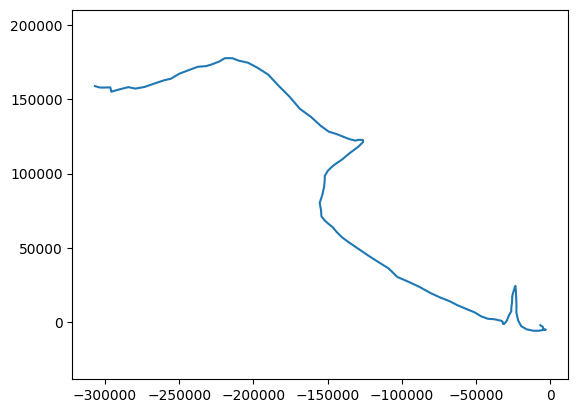

In [4]:
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


In [5]:
rho_core_thresh = 30000
# rho_outer_core_thresh = 80000

dic_k = {}

for t in range(len(df_res)):
    surf = df_res.iloc[t]
    ut, vt = dic_ssh_data[surf.Time]['u'], dic_ssh_data[surf.Time]['v']

    xc_pre, yc_pre = surf.sxc, surf.syc
    q11_pre, q12_pre, q22_pre = surf.sq11, surf.sq12, surf.sq22

    rows = [{
        'xc': surf.sxc, 'yc': surf.syc, 'w': surf.sw,
        'q11': surf.sq11, 'q12': surf.sq12, 'q22': surf.sq22,
        'Rc': surf.sRc, 'psi0': surf.spsi0, 'A': surf.sA,
        'r2_1': surf.r2_1, 'r2_2': surf.r2_2, 'Depth': z_ssh[0]
    }]

    for k in range(1, 33):
        utk, vtk = ut[:, :, k], vt[:, :, k]

        dx, dy = x_ssh - xc_pre, y_ssh - yc_pre 
        rho2 = q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2
        rho_search = np.sqrt(np.where(rho2 < 0, np.nan, rho2))
        mask_core = rho_search < rho_core_thresh

        if not np.any(mask_core):
            break

        xi, yi = x_ssh[mask_core], y_ssh[mask_core]
        ui, vi = utk[mask_core], vtk[mask_core]
        xc, yc, w, Q, Rc, psi0, A0, r2_1, r2_2 = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)

        # All
        radii = find_directional_radii(utk, vtk, x_ssh, y_ssh, xc, yc, Q)
        R = np.mean([radii['up'], radii['right'], radii['down'], radii['left']])

        mask_outer = rho_search < max(min(1.75*R, 200000), rho_core_thresh)
        axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], utk[mask_outer], vtk[mask_outer]

        if (np.hypot(xc - xc_pre, yc - yc_pre) < 100000) and (w < 0) and (A0 < 0):

            df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
            df = df[df.vt < 0]
            Rc, psi0, A, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0,
                                               Rc_max=200000, r2_flag=True)
            if A >= 0:
                Rc, psi0, A, r2_2 = np.nan, np.nan, A0, np.nan

            q11, q12, q22 = Q[0, 0], Q[1, 0], Q[1, 1]
            rows.append({'xc': xc, 'yc': yc, 'w': w, 'q11': q11, 'q12': q12, 'q22': q22,
                         'Rc': Rc, 'psi0': psi0, 'A': A, 'R': R, 'r2_1': r2_1, 'r2_2': r2_2, 'Depth': z_ssh[k]})
            xc_pre, yc_pre = xc, yc
            q11_pre, q12_pre, q22_pre = q11, q12, q22
        else:
            break

    df_res_k = pd.DataFrame(rows, columns=['xc','yc','w','q11','q12','q22','Rc','psi0','A','R','r2_1','r2_2','Depth'])

    wdw = 5
    df_res_k['sw'] = smooth(df_res_k.w, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['sq11'] = smooth(df_res_k.q11, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['sq12'] = smooth(df_res_k.q12, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['sq22'] = smooth(df_res_k.q22, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['sRc'] = smooth(df_res_k.Rc, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['spsi0'] = smooth(df_res_k.psi0, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    df_res_k['sA'] = smooth(df_res_k.A, df_res_k.Depth, window=wdw, num=len(df_res_k)) 
    
    dic_k[surf.Time] = df_res_k


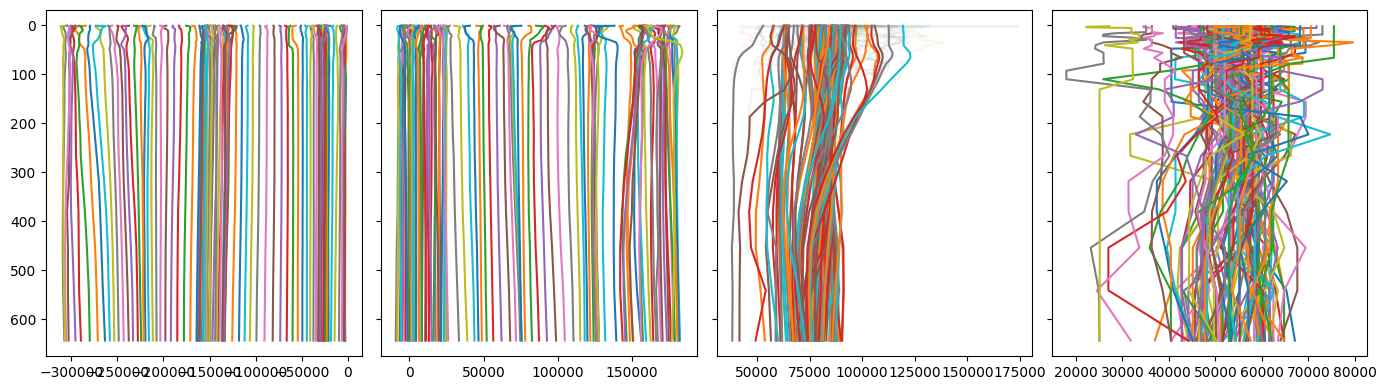

In [6]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,4))
for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]
    axs[0].plot(df.xc, df.Depth)
    axs[1].plot(df.yc, df.Depth)
    axs[2].plot(df.Rc, df.Depth, alpha=.1)
    axs[2].plot(df.sRc, df.Depth)
    axs[3].plot(df.R, df.Depth)
axs[0].invert_yaxis()
plt.tight_layout()
    

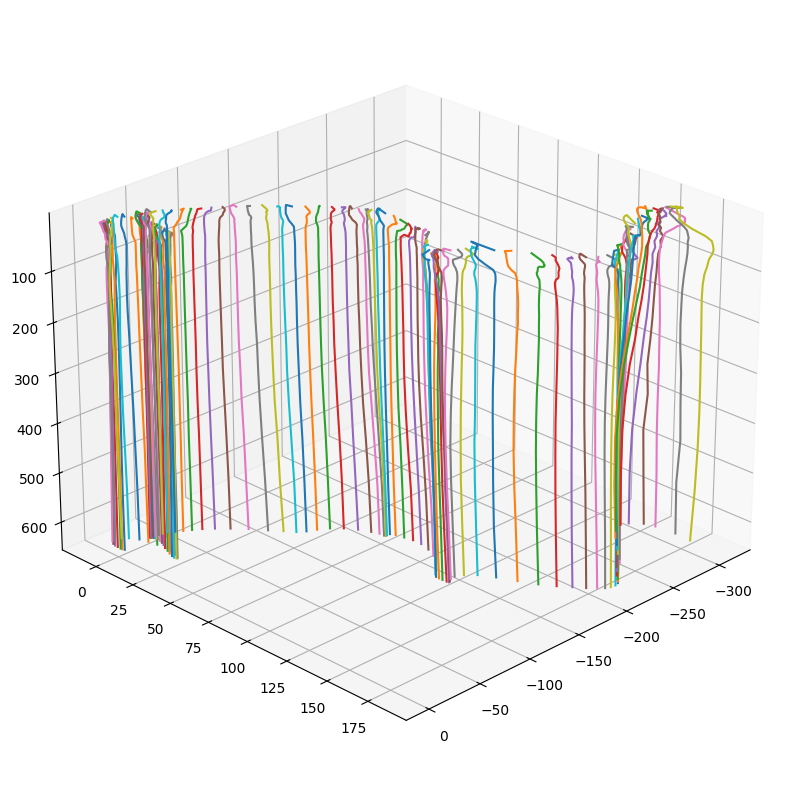

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for time, df in dic_k.items():
    ax.plot(df.xc/1e3, df.yc/1e3, df.Depth)

ax.view_init(elev=25, azim=45)

ax.invert_zaxis()


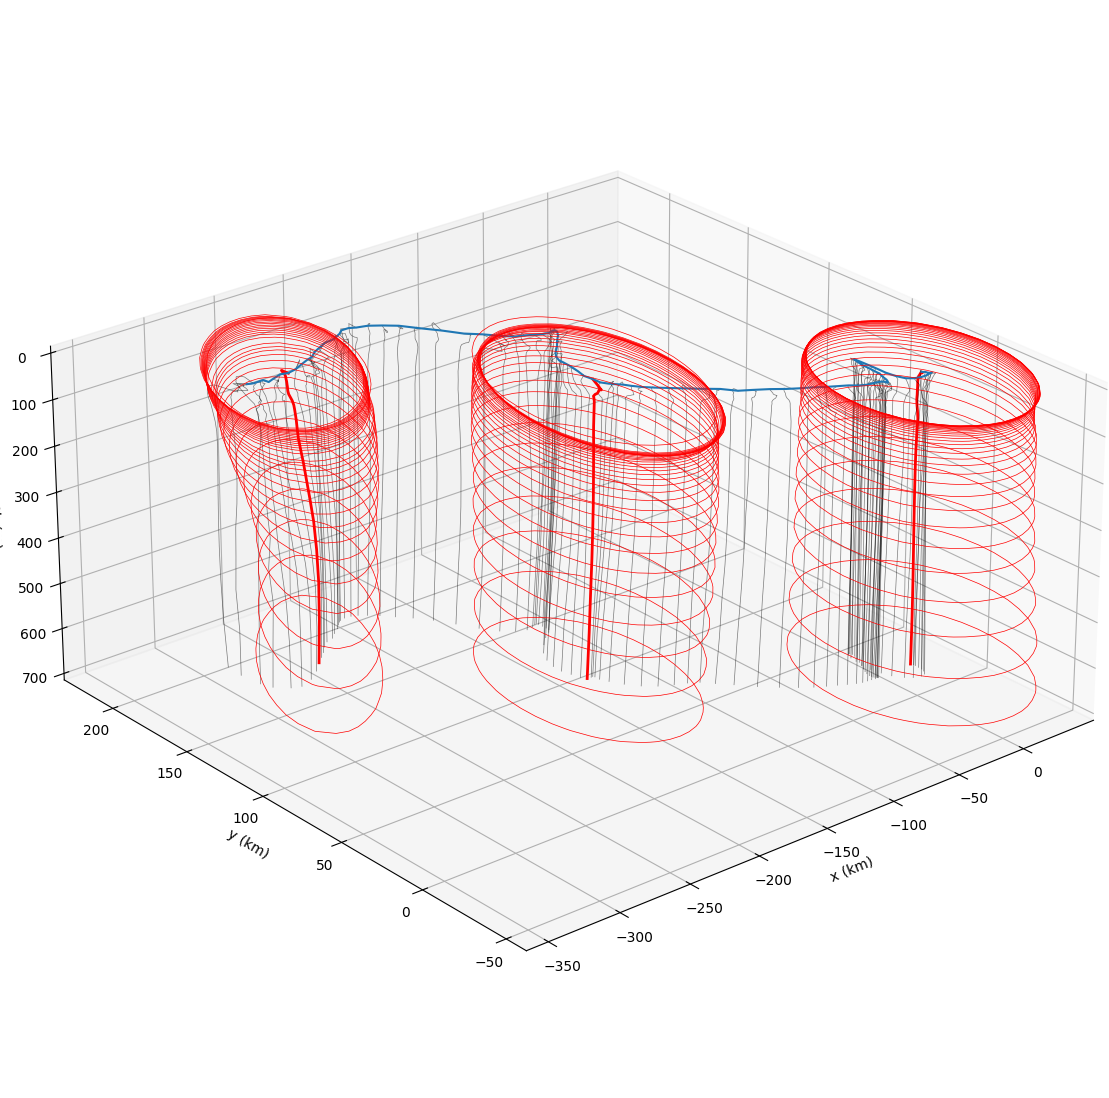

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

for t, (time, df) in enumerate(dic_k.items()):

    if  t in [0, 60, 100]:
        for k in range(len(df)):
            # --- Ellipse contours ---
            data = df.iloc[k]
            dx_ell = x_ssh/1e3 - data.xc/1e3
            dy_ell = y_ssh/1e3 - data.yc/1e3
            rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
            ax.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
                         colors='r', zdir='z', offset=data.Depth, linewidths=.5)

        ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='r', 
        alpha=1, lw=2)
    else:
        ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', 
        alpha=.5, lw=.5)

ax.plot(df_res.sxc/1e3, df_res.syc/1e3, [0]*len(df_res))

ax.view_init(elev=25, azim=230)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('Depth (m)')
ax.invert_zaxis()

gap = 50
ax.set_xlim(df_res.sxc.min()/1e3 - gap, df_res.sxc.max()/1e3 + gap);
ax.set_ylim(df_res.syc.min()/1e3 - gap, df_res.syc.max()/1e3 + gap);
ax.set_zlim(700, 0)
ax.set_box_aspect((.1, .1, .05))


In [ ]:
U = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))

for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]

    for k in range(len(df)):
        data = df.iloc[k]
        dx, dy = x_ssh - data.xc, y_ssh - data.yc
        rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    
        U[:,:,k,t_idx] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
        V[:,:,k,t_idx] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

        OW[:,:,k,t_idx] = calc_ow(U[:,:,k,t_idx].T, V[:,:,k,t_idx].T, X[1,0] - X[0,0], Y[0,1] - Y[0,0]).T
    OW[:,:,:,t_idx] = normalize_matrix(OW[:,:,:,t_idx])


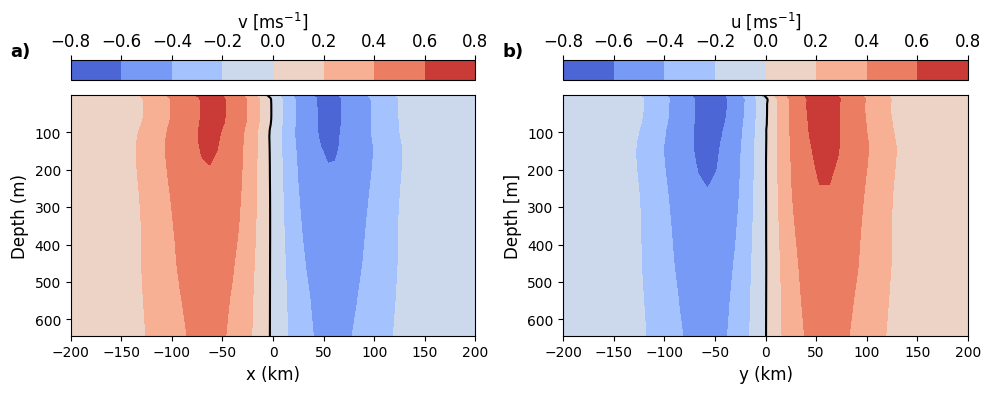

In [52]:
t_sadcp = pd.Timestamp('2023-10-19 18:00:00')
closest = min(df_res.Time, key=lambda tt: abs(tt - t_sadcp)) 

t_idx = df_res[df_res.Time==closest].iloc[0].name

df = dic_k[closest]



xc_surf, yc_surf = df_res.iloc[t_idx].xc, df_res.iloc[t_idx].yc
ic_surf = np.argmin(np.abs(x_ssh[:,0] - xc_surf))
jc_surf = np.argmin(np.abs(y_ssh[0,:] - yc_surf))
z_lvl_max = 33

fig, axs = plt.subplots(1, 2, figsize=(10,4))
ax = axs[0]
c1 = ax.contourf(x_ssh[:,0]/1e3, z_ssh[:z_lvl_max], V[:, jc_surf, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df.xc/1e3, df.Depth, color='k', label='Center Line')
ax.invert_yaxis()
# ax.legend(loc='lower left')
cb = fig.colorbar(c1, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
ax.set_xlabel('x (km)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.text(-0.15, 1.22, 'a)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax.set_xlim(-200, 200)

# --- (3): Zonal section (u) ---
ax = axs[1]
c2 = ax.contourf(y_ssh[0,:]/1e3, z_ssh[:z_lvl_max], U[ic_surf, :, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df.yc/1e3, df.Depth, color='k', label='Center Line')
ax.invert_yaxis()
# ax.legend(loc='lower left')
cb = fig.colorbar(c2, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)
ax.set_xlabel('y (km)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.text(-0.15, 1.22, 'b)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax.set_xlim(-200, 200)

plt.tight_layout()


np.int64(1)

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

for t, (time, df) in enumerate(dic_k.items()):

    if  t in [0, 60, 100]:
        for k in range(len(df)):
            # --- Ellipse contours ---
            data = df.iloc[k]
            dx_ell = x_ssh/1e3 - data.xc/1e3
            dy_ell = y_ssh/1e3 - data.yc/1e3
            rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
            ax.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
                         colors='r', zdir='z', offset=data.Depth, linewidths=.5)

        ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='r', 
        alpha=1, lw=2)
    else:
        ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', 
        alpha=.5, lw=.5)

ax.plot(df_res.sxc/1e3, df_res.syc/1e3, [0]*len(df_res))

ax.view_init(elev=25, azim=230)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('Depth (m)')
ax.invert_zaxis()

gap = 50
ax.set_xlim(df_res.sxc.min()/1e3 - gap, df_res.sxc.max()/1e3 + gap);
ax.set_ylim(df_res.syc.min()/1e3 - gap, df_res.syc.max()/1e3 + gap);
ax.set_zlim(700, 0)
ax.set_box_aspect((.1, .1, .05))

,xc,yc,w,Q,Rc,psi0,A,R,r2_1,Time,...,syc,sq11,sq12,sq22,sRc,sA,sw,spsi0,Data,Method
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",82489.584746,62022.052721,-0.000009,50994.258383,0.992436,2023-10-19 00:00:00,...,-2108.042418,0.972914,-0.103055,1.041144,81761.802118,-0.000009,-0.000037,61442.129397,Numerical,ESPRA
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",74568.109930,55579.064827,-0.000010,46377.603892,0.989580,2023-10-19 23:56:15,...,-2721.266111,0.947328,-0.107706,1.072288,81546.298896,-0.000009,-0.000037,61390.726539,Numerical,ESPRA
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",88487.582092,66281.323785,-0.000008,54708.334682,0.990015,2023-10-21 00:00:00,...,-3128.339941,0.921162,-0.099094,1.103794,81396.843209,-0.000009,-0.000038,61415.338083,Numerical,ESPRA
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",76534.917427,57823.499341,-0.000010,46886.419213,0.993006,2023-10-22 00:00:00,...,-4053.698867,0.899001,-0.076631,1.131550,81328.419122,-0.000009,-0.000038,61525.555770,Numerical,ESPRA
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",78526.099342,59201.426383,-0.000010,50593.667161,0.992719,2023-10-22 23:56:15,...,-5278.160402,0.864076,-0.039283,1.175821,80895.740614,-0.000009,-0.000038,61522.714021,Numerical,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",56270.574725,21072.628684,-0.000007,42245.696889,0.933604,2024-01-31 00:00:00,...,158109.922928,0.951670,-0.101967,1.235045,71348.037352,-0.000005,-0.000022,25967.053413,Numerical,ESPRA
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",52575.980680,19570.681995,-0.000007,36286.868478,0.913641,2024-02-01 00:00:00,...,157995.891402,1.219022,0.051441,1.070873,69669.664384,-0.000005,-0.000023,24660.983574,Numerical,ESPRA
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",65634.448641,26654.913656,-0.000006,34514.576102,0.947802,2024-02-02 00:00:00,...,157985.201138,1.566723,0.167942,0.934028,69561.464185,-0.000005,-0.000025,24077.010440,Numerical,ESPRA
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",105309.297693,35476.409498,-0.000003,34974.184189,0.941040,2024-02-02 23:56:15,...,158292.110118,1.725037,0.282861,0.819334,68751.412943,-0.000005,-0.000025,23395.150273,Numerical,ESPRA


(np.float64(-467868.1264979113),
 np.float64(327725.45653936424),
 np.float64(-459725.141143799),
 np.float64(437524.9294281004))

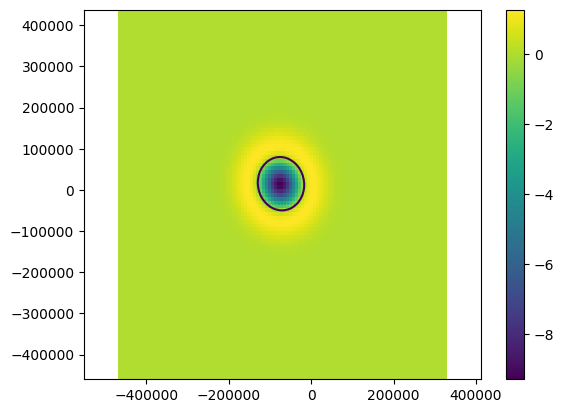

In [23]:
t_idx = 44
k = 32
plt.pcolor(X, Y, OW[:,:,k,t_idx])
plt.colorbar()
plt.contour(X, Y, OW[:,:,k,t_idx], levels=[-0.2])
plt.axis('equal')


In [11]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from skimage import measure

# for t_idx in range(len(dic_k)):
#     if t_idx not in [41, 42, 43]:
#         time = list(dic_k.keys())[t_idx]
#         df_t = dic_k[time].copy().sort_values('Depth')
        
#         depth_new = np.arange(df_t['Depth'].min(), df_t['Depth'].max() + 50, 50)
#         idx = pd.Index(np.union1d(df_t['Depth'].to_numpy(), depth_new))
#         df = (df_t.set_index('Depth')
#                   .reindex(idx)
#                   .interpolate(method='index', limit_area='inside')
#                   .loc[depth_new]
#                   .reset_index()
#                   .rename(columns={'index': 'Depth'}))
        
#         z = df.Depth
#         dz = z[1] - z[0]
#         dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3
        
#         verts, faces, normals, values = measure.marching_cubes(OW[:,:,:,t_idx], level=-0.2, spacing=(dx, dy, dz))
#         verts[:,0] += X.min()/1e3
#         verts[:,1] += Y.min()/1e3
#         verts[:,2] += z.min()
        
#         fig = plt.figure(figsize=(10,8))
#         ax = fig.add_subplot(111, projection='3d')
        
#         mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
#         mesh.set_zsort('min')
#         ax.add_collection3d(mesh)
        
#         ax.set_xlim(X.min()/1e3, X.max()/1e3)
#         ax.set_ylim(Y.min()/1e3, Y.max()/1e3)
#         ax.set_zlim(0, 3000)# z.max())
        
#         ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', lw=2, label='Center Line')
#         ax.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')
        
#         ax.invert_zaxis()
#         ax.set_box_aspect((.1, .1, .09))
#         ax.view_init(elev=25, azim=45)
#         ax.set_xlabel('x (km)')
#         ax.set_ylabel('y (km)')
#         ax.set_zlabel('Depth (m)')
#         # ax.legend()
        
#         fig.suptitle(f'{time}')
#         plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_sat_data/3D_OW_isobath_plots/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#         plt.close()


Text(0.5, 0, 'Depth (m)')

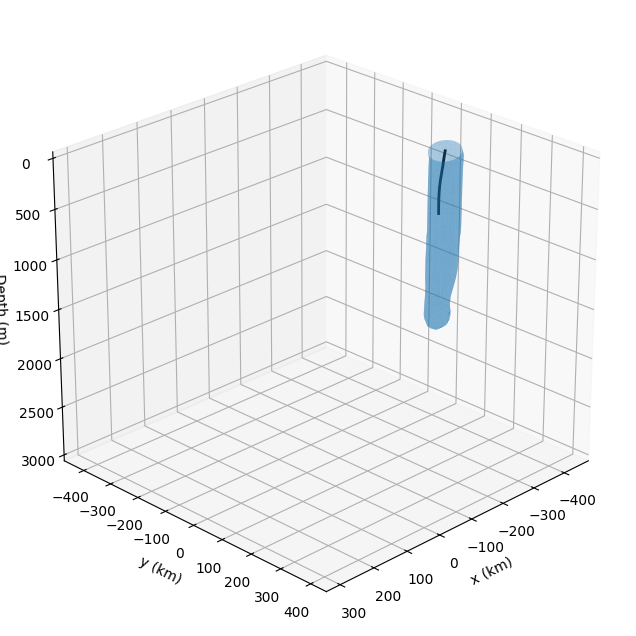

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

t_idx = 100

time = list(dic_k.keys())[t_idx]
df_t = dic_k[time].copy().sort_values('Depth')

depth_new = np.arange(df_t['Depth'].min(), df_t['Depth'].max() + 50, 50)
idx = pd.Index(np.union1d(df_t['Depth'].to_numpy(), depth_new))
df = (df_t.set_index('Depth')
          .reindex(idx)
          .interpolate(method='index', limit_area='inside')
          .loc[depth_new]
          .reset_index()
          .rename(columns={'index': 'Depth'}))

z = df.Depth
dz = z[1] - z[0]
dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3

verts, faces, normals, values = measure.marching_cubes(OW[:,:,:,t_idx], level=-0.2, spacing=(dx, dy, dz))
verts[:,0] += X.min()/1e3
verts[:,1] += Y.min()/1e3
verts[:,2] += z.min()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
mesh.set_zsort('min')
ax.add_collection3d(mesh)

ax.set_xlim(X.min()/1e3, X.max()/1e3)
ax.set_ylim(Y.min()/1e3, Y.max()/1e3)
ax.set_zlim(0, 3000)# z.max())

ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', lw=2, label='Center Line')
ax.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')

ax.invert_zaxis()
ax.set_box_aspect((.1, .1, .09))
ax.view_init(elev=25, azim=45)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

